# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [30]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


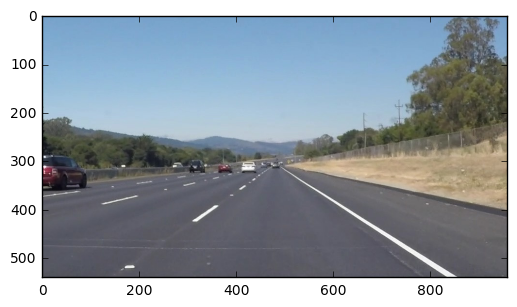

In [31]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [32]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def get_slope(line):
    #print (flat)
    x1,y1,x2,y2 = line.flatten()
    if x2 == x1: 
        return 1000.0 #conversion to int does not work if use math.inf. This is large enough for our images. 
    return (y2-y1) / (float) (x2-x1)
def debug_print(first_lane, second_lane, average_slope_first, average_slope_second): 
    print ('Average slope ' + str(average_slope_first) + ' ' + str(average_slope_second))

    print ('Number of lines first lane ' + str(len(first_lane)))
    print ('Number of lines second lane ' + str(len(second_lane)))
    
    print ('FIRST LANES ---------')
    for line in first_lane: 
        print (line)
        print ('Slope is ' + str(get_slope(line)))


    print ('SECOND LANES --------')
    for line in second_lane: 
        print (line)
        print ('Slope is ' + str(get_slope(line)))
        
def update_bin(segments, line, average_slope, line_slope): 
    average_slope = (average_slope * len(segments) + line_slope) / (len(segments) + 1)
    segments.append(line)
    return (segments, average_slope)

def get_longest_line(segments):
    if len(segments) ==0: 
        return None
    longest = segments[0]
    max_length = 0
    
    for line in segments: 
        for x1,y1,x2,y2 in line: 
            length = (x1-x2)*(x1-x2) + (y1-y2)*(y1-y2) #technical not length, but for comparision it's ok
            if length > max_length: 
                max_length = length
                longest = line
    return longest

"""
    extrapolate to y_min and y_max using slope equation
"""
def get_lane_tips(line, y_min, y_max):
    if line == None: 
        return (0, int(y_min), 0, int(y_max))
    x1,y1,x2,y2 = line.flatten()
    slope = get_slope(line)
    if slope == 0.0: 
        return (0, int(y_min), 0, int(y_max))
    x_max = x1 - (y1 - y_max) / slope
    x_min = x1 - (y1 - y_min) / slope
    #print (str(x_min) + " " + str(y_min) + " " + str(x_max) + " " + str(y_max) + " slope " + str(slope))
    return (int(x_min), int(y_min), int(x_max), int(y_max))
def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #need a kind of merging together
    #segment_label = [0] * len(lines)
    
    first_lane = [] #all lines of first lane
    second_lane = [] #all lines of second lane
    second_lane_revised = [] #remove items from second_lane that deviates too much from the mean
    average_slope_first = 0.0
    average_slope_second = 0.0 
    
    #this strategy will not work if a "wrong" line is accidentally chosen for the first bin
    #our data set is relatively "straightforward", so this strategy seems to work fine
    for line in lines: 
        slope = get_slope(line)
        if abs(slope) > 0.5: #take into account only line that has the direction with our fixed mounted camera
            if average_slope_first == 0 or abs(average_slope_first - slope) <= 0.1:
                first_lane, average_slope_first = update_bin(first_lane, line, average_slope_first, slope) 
            else:
                second_lane, average_slope_second = update_bin(second_lane, line, average_slope_second, slope) 
    
    for line in second_lane: 
        if abs(get_slope(line) - average_slope_second) < 0.2: #eliminate outliners 
            second_lane_revised.append(line) 
            
    #debug_print(first_lane, second_lane_revised, average_slope_first, average_slope_second)
    
    #fine longest line now, and extrapolate in the y range y/2 -> y
    longest_line_first_lane = get_longest_line(first_lane)
    if len(second_lane_revised) == 0:
        second_lane_revised = second_lane
    longest_line_second_lane = get_longest_line(second_lane_revised)

    bottom_offset_y = 10
    y_max = img.shape[0] - bottom_offset_y           #clamp to our region of interest
    y_min = img.shape[0] / 2 + 50
    
    x1_1, y1_1, x2_1, y2_1 = get_lane_tips(longest_line_first_lane, y_min, y_max)
    x1_2, y1_2, x2_2, y2_2 = get_lane_tips(longest_line_second_lane, y_min, y_max)

    cv2.line(img, (x1_1, y1_1), (x2_1, y2_1), color, thickness)

    cv2.line(img, (x1_2, y1_2), (x2_2, y2_2), color, thickness)

    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

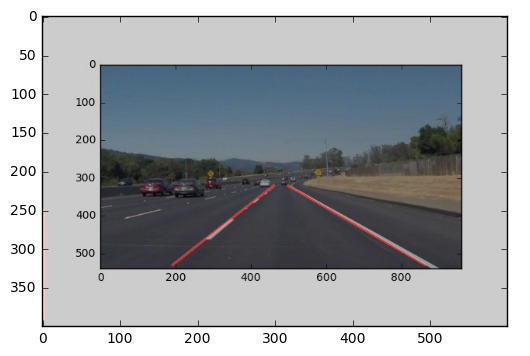

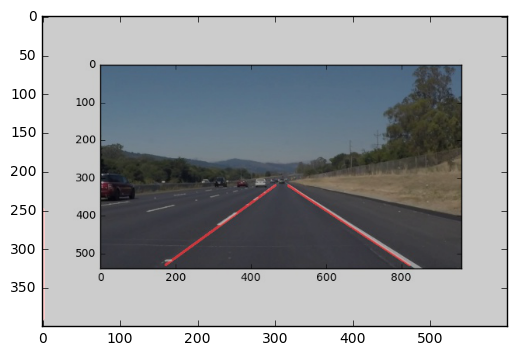

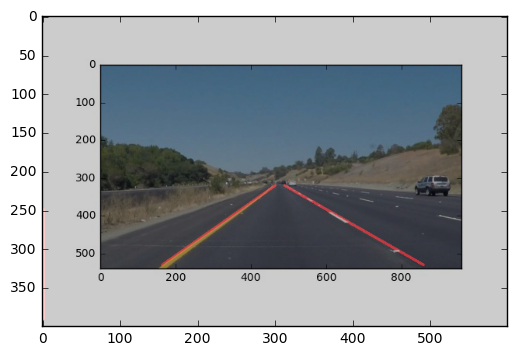

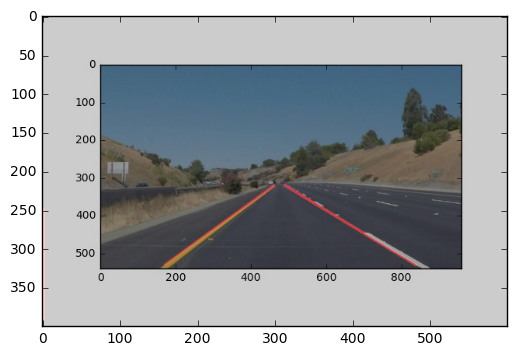

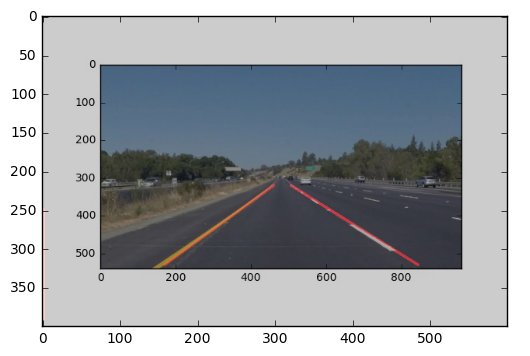

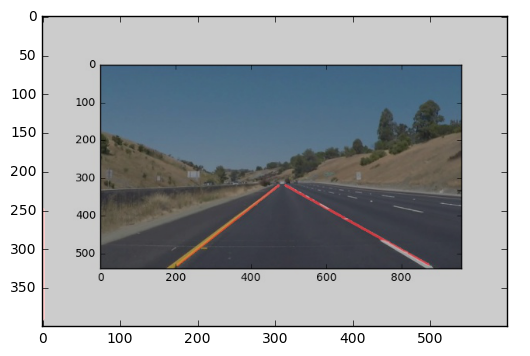

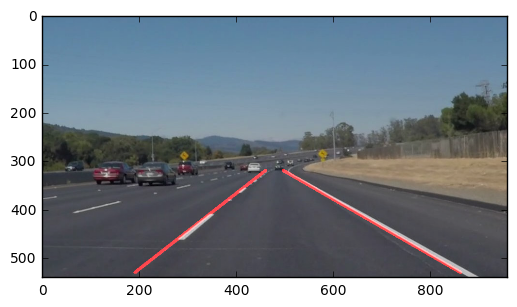

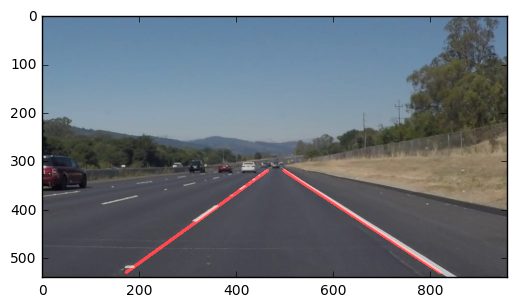

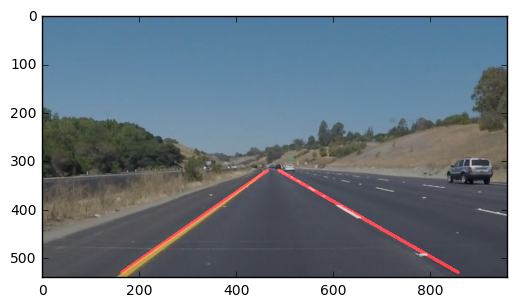

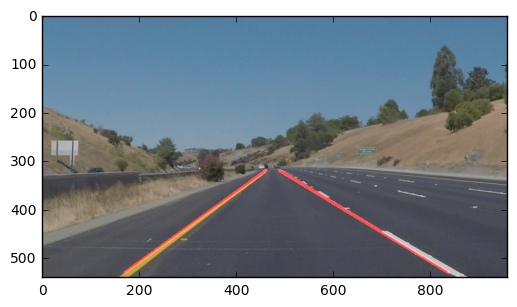

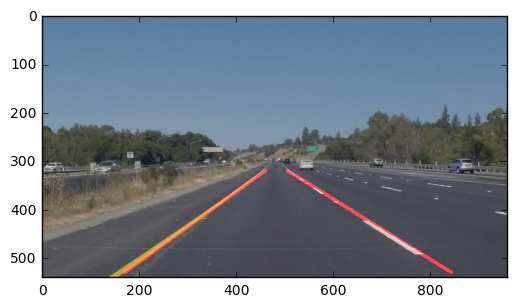

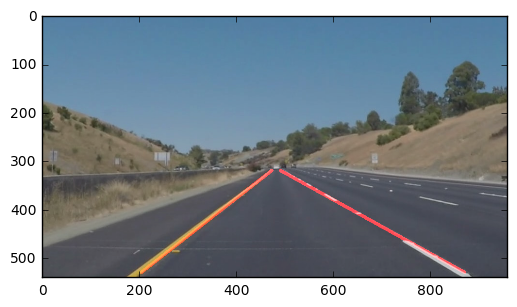

In [33]:
import os

def overlay_lane(image):

    gray = grayscale(image)
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    mask = np.zeros_like(edges)
    ignore_mask_color = 255
    #define a masked polygon
    imshape = image.shape
    bottom_offset_y = 20
    left_offset = 100
    right_offset = 100
    vertices = np.array([[(left_offset, imshape[0] - bottom_offset_y), \
                          (imshape[1]/2.0-10, imshape[0]/2.0 + 40), \
                          (imshape[1]/2.0-5, imshape[0]/2.0 + 40),  \
                          (imshape[1]-right_offset, imshape[0] - bottom_offset_y)]], dtype=np.int32)  
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)

    rho = 1 #distance in pixel of Hough grid
    theta = np.pi / 180.0 #angular resolution in radians of Hough grid
    threshold = 20 #min number of votes (intersection in Hough grid cell) 
    min_line_length = 10 #minimum number of pixels making up a line  
    max_line_gap = 10 #maximum gap in pixels between connectable line segments
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    
    combined_image = weighted_img(line_image, image)
             
    #color_edges = np.dstack((edges, edges, edges))
    #lines_edges = addWeighted(color_edges, line_image)
                            
    #plt.imshow(gray, cmap='gray')
    #plt.figure()
    return combined_image

image_folder = 'test_images/'
image_names = os.listdir(image_folder)
for image_name in image_names:
    full_path = os.path.join(image_folder, image_name)
    if (not image_name.startswith('.')) and os.path.isfile(full_path):
        image = mpimg.imread(full_path)
        combined_image = overlay_lane(image)
        plt.imshow(combined_image)
        #plt.savefig('test_images/edges_overlayed_'+image_name)
        plt.figure()
    


run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [23]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # you should return the final output (image with lines are drawn on lanes)
    
    return overlay_lane(image)

Let's try the one with the solid white lane on the right first ...

In [24]:
def write_clip(input_file, output_file): 
    input_clip = VideoFileClip(input_file)
    output_clip = input_clip.fl_image(process_image) #NOTE: this function expects color images!!
    %time output_clip.write_videofile(output_file, audio=False)

write_clip('solidWhiteRight.mp4', 'white.mp4')
#write_clip('solidYellowLeft.mp4', 'yellow.mp4')



  self.nchannels))




[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  0%|          | 0/222 [00:00<?, ?it/s]WARNING:py.warnings:/Users/long/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:88: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.

100%|█████████▉| 221/222 [00:05<00:00, 40.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 2.57 s, sys: 868 ms, total: 3.44 s
Wall time: 6.31 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("white.mp4"))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [25]:
write_clip('solidYellowLeft.mp4', 'yellow.mp4')

  self.nchannels))




[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  0%|          | 0/682 [00:00<?, ?it/s]WARNING:py.warnings:/Users/long/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:88: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.

100%|█████████▉| 681/682 [00:18<00:00, 36.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 8.47 s, sys: 1.59 s, total: 10.1 s
Wall time: 19.4 s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("yellow.mp4"))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

### Answer
Very interesting first assignment. All the images, templates, Anaconda package is a great way to get started. 

The lane detection pipeline has been tuned specifically for the acquired images and video (it runs also relatively well on the challenge video. It can be improved further, but it could then fall in the trap of local optimization). 

As can be seen especially in the line "stiching" part, a couple of optimization has been done to make the algorithm more robust: 
1. Eliminate lines that has weird orientation (compared to the camera position assumption)
2. Eliminate lines that are outliners compared to the rest (compared to average of slope) 

A couple of assumptions of the algorithm/ things can be improved: 
1. Camera is mounted on fixed position, and camera angle/resolution stays fixed (so the region of interest definition could work). Maybe a better/ more dynamic way of determining the region of interest, e.g. multiple iterations, each iteration check the quality of the found lines. This could improve the quality of the challenge video. 

2. Categorizing line segments into 2 lanes can be done iteratively (multiple iterations) to prevent outliners being put to a certain bin first, which could lead to wrong categorization. Something similar to k-nearest neighbour clustering algorithm can be done here (different lane segments can be categorized to be in 1 cluster, if its slope is "close" to the center slope). However, since the data set is relatively "clean", the k-clustering has not been tried out here. 




## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [26]:
write_clip('challenge.mp4', 'extra.mp4')

  self.nchannels))




[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


  0%|          | 0/251 [00:00<?, ?it/s]WARNING:py.warnings:/Users/long/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:88: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.

100%|██████████| 251/251 [00:13<00:00, 18.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 6.26 s, sys: 2.04 s, total: 8.3 s
Wall time: 14.9 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("extra.mp4"))